## Developed by: Saad Aldin Mohamed
## email: sa3danny@yahoo.com

In [1]:
# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 4)

# Ignore useless warnings
import warnings
warnings.simplefilter("ignore", UserWarning)

# ------------------------------------- Data preparation -------------------------------------------

In [2]:
activation_data = pd.read_excel('Activation_status_data.xlsx')
activation_data.head(3)

,name,activated,N2_BET,N2_Langmiur,last solvent,method
0,ACAJIZ_clean,yes,0.0,0.0,chloroform,exchange
1,ACAJOF_clean,yes,0.0,0.0,chloroform,exchange
2,ACUFEK_clean,yes,NaN,3800.0,dichloromethane,exchange


In [3]:
activation_data['activated'].unique()

array(['yes', nan, 'no', 'dup-remove', 'hypo-remove'], dtype=object)

In [4]:
## Remove duplicate and hypothetical enteries
dup_remove = activation_data[activation_data['activated']=='dup-remove'].index
hypo_remove = activation_data[activation_data['activated']=='hypo-remove'].index
activation_data = activation_data.drop(dup_remove)
activation_data = activation_data.drop(hypo_remove)

print ('Removed duplicate enteries = ', len(dup_remove))
print ('Removed hypothetical enteries = ', len(hypo_remove))
print ('size of the remaining data = ', len(activation_data))

Removed duplicate enteries =  49
Removed hypothetical enteries =  6
size of the remaining data =  280


# -------------------------- Reduction in surface area ------------------------------------

In [5]:
#Import theoretical surface area for all the CORE database
geom_data = pd.read_csv("2019-11-01-ASR-public_12020.csv")
theoretical_ASA = geom_data[['filename', 'ASA_m2_g']]
theoretical_ASA = pd.DataFrame(theoretical_ASA)
theoretical_ASA.rename(columns = {'filename':'name'}, inplace=True)

In [6]:
#Merge the experimental surface area with the theoretical surface area
surface_data  = pd.merge(theoretical_ASA, activation_data[['name','N2_BET','N2_Langmiur']], on = 'name', how = 'inner')

surface_data.head(3)

,name,ASA_m2_g,N2_BET,N2_Langmiur
0,ACAJIZ_clean,753.879,0.0,0.0
1,ACAJOF_clean,920.046,0.0,0.0
2,ACUFEK_clean,3941.720,NaN,3800.0


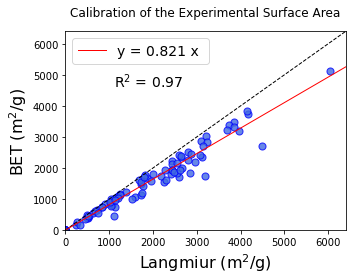

In [7]:
## plot the experimental BET vs Langmiur

BET_vs_Langmiur = surface_data.copy()
BET_vs_Langmiur = BET_vs_Langmiur.dropna(subset = ['N2_BET']) # drop the rows with nan 
BET_vs_Langmiur = BET_vs_Langmiur.dropna(subset = ['N2_Langmiur']) # drop the rows with nan

#----------------------- liner fitting (with zero intercept) -------------------------------#

from sklearn.linear_model import LinearRegression
X = BET_vs_Langmiur ['N2_Langmiur']
X = np.array(X).reshape(-1, 1)
y = BET_vs_Langmiur ['N2_BET']
y = np.array(y)
reg = LinearRegression(fit_intercept=False).fit(X, y)
score = reg.score(X,y)
slope = reg.coef_
intercept = reg.intercept_


#---------------------- scatter plot ---------------------------------#

Langmiur = BET_vs_Langmiur ['N2_Langmiur']
BET = BET_vs_Langmiur ['N2_BET']

xs = np.arange(0,8000,100)
line_y = xs
y_model = slope*(xs) # the intercept was set to zero

plt.figure(figsize=(5,4))
plt.scatter(x = Langmiur, y = BET, s =50, c = 'royalblue', edgecolor ='blue', alpha = 0.8)

line, = plt.plot(xs, line_y, "k--", linewidth=1)  # diagonal line
model, = plt.plot(xs, y_model, "r-", linewidth=1)  # fitted

plt.title ("Calibration of the Experimental Surface Area", fontsize = 12, pad=15)
plt.xlabel("Langmiur (m${^2}$/g)", fontsize = 16)
plt.ylabel("BET (m${^2}$/g)", fontsize = 16)
plt.axis([0, 6400, 0, 6400])

#-------------------------- print text --------------------------------#

txt_1 = 'y = ' + str("%0.3f " % slope[0]) + 'x ' 
txt_2 = "R$^{2}$ = " + str("%0.2f " % score)
plt.legend(['_nolegend_', txt_1 ,'_nolegend_'], loc='upper left', fontsize=14)
#plt.text(800, 5700, txt_1, fontsize=14)
plt.text(1100, 4600, txt_2, fontsize=14)
plt.tight_layout()

plt.savefig("Calibrating Experimental Surface Area.png", dpi=200)

In [8]:
#fill the nan in BET enteries with fitted model, if exist a langmiur value
fill_BET = surface_data.copy()
fill_BET = fill_BET.dropna(subset = ['N2_BET', 'N2_Langmiur'],
                         how= 'all') # drop columns where both BET and Langmiur are 'nan'

fitted = slope*fill_BET['N2_Langmiur']
fill_BET['N2_BET'] = fill_BET['N2_BET'].fillna(fitted)

fill_BET.head(10)

,name,ASA_m2_g,N2_BET,N2_Langmiur
0,ACAJIZ_clean,753.879,0.000000,0.0
1,ACAJOF_clean,920.046,0.000000,0.0
2,ACUFEK_clean,3941.720,3119.939044,3800.0
3,ADASAB_charged,4829.510,880.000000,1030.0
4,ADASEF_clean,4179.020,1740.000000,3180.0
5,ADASIJ_clean,3491.360,1070.000000,1590.0
7,ADOGEH_clean,1958.140,1834.000000,NaN
8,AGOFEJ_clean,3357.770,0.000000,0.0
9,ALAMUW_clean,3766.220,2011.539647,2450.0
12,ANUGEW_clean,4708.570,0.000000,0.0


<AxesSubplot:>

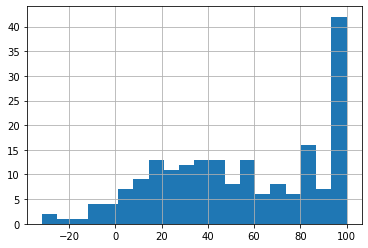

In [9]:
#plot histogram of the surface area reduction
reduction_data = fill_BET.copy()

#remove data with zero theoretical values, to avoid infinity in the estimated reduction value
ind = reduction_data[reduction_data['ASA_m2_g'] == 0].index 
reduction_data = reduction_data.drop(ind)
reduction_data['reduction'] = 100*(reduction_data['ASA_m2_g'] - reduction_data['N2_BET'])/reduction_data['ASA_m2_g']
reduction_data['reduction'].hist(bins= 20)

<AxesSubplot:>

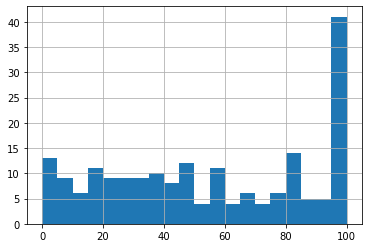

In [10]:
#if the reduction is less than zero, then round it to zero
#in other words, if the experimental BET is bigger than theortical value, then the reduction can be taken as zero
reduction_data.loc[(reduction_data.reduction < 0),'reduction']=0
reduction_data['reduction'].hist(bins= 20)

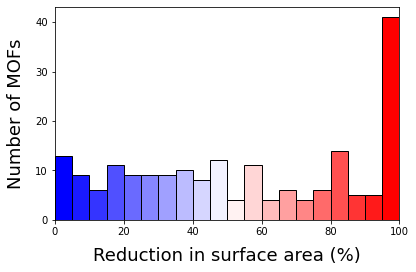

In [11]:
# Plot a nice histogram

#----------------------- Plot histogram--------------------------------#
n_bins = 20
n, bins, patches = plt.hist(reduction_data['reduction'], bins = n_bins, color='r', edgecolor = 'k')

#--------------------- generate a color gradient-------------------------#
from colour import Color
main_color = Color("dodgerblue")
colors = list(main_color.range_to(Color("orangered"),n_bins))
colors = [color.rgb for color in colors]
cm = plt.cm.get_cmap('bwr')

bin_centers = 0.5 * (bins[:-1] + bins[1:])
columns = bin_centers - min(bin_centers)
columns /= max(columns)
for c, p in zip(columns, patches):
    plt.setp(p, 'facecolor', cm(c))
      
#---------------------------- other settings ---------------------------#
plt.xlabel("Reduction in surface area (%)", fontsize=18, labelpad=10)
plt.ylabel("Number of MOFs", fontsize=18, labelpad=10)
plt.xlim([0, 100])
plt.rc('font', size=14)
plt.rc('axes', titlesize=14)
plt.tight_layout()
plt.savefig("Surface area reduction histogram.png", dpi=200)